In [1]:
import pandas as pd

df = pd.read_csv('credit_card_data.csv', skiprows = 1)

df.set_index('ID', inplace=True)

df.head()

df.columns.value

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
df.columns = df.columns.str.lower()
df.rename({'default payment next month': 'default'}, axis= 1, inplace= True)

In [11]:
# no nulls, 30k data points
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
limit_bal    30000 non-null int64
sex          30000 non-null int64
education    30000 non-null int64
marriage     30000 non-null int64
age          30000 non-null int64
pay_0        30000 non-null int64
pay_2        30000 non-null int64
pay_3        30000 non-null int64
pay_4        30000 non-null int64
pay_5        30000 non-null int64
pay_6        30000 non-null int64
bill_amt1    30000 non-null int64
bill_amt2    30000 non-null int64
bill_amt3    30000 non-null int64
bill_amt4    30000 non-null int64
bill_amt5    30000 non-null int64
bill_amt6    30000 non-null int64
pay_amt1     30000 non-null int64
pay_amt2     30000 non-null int64
pay_amt3     30000 non-null int64
pay_amt4     30000 non-null int64
pay_amt5     30000 non-null int64
pay_amt6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(24)
memory usage: 5.7 MB


In [34]:
df.describe().iloc[:,5:]

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [16]:
# drop the education = 0 and marriage = 0 they are likely unknowns
df.education.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: education, dtype: int64

In [17]:
df.marriage.value_counts()

2    15964
1    13659
3      323
0       54
Name: marriage, dtype: int64

In [61]:
df.drop(df[df['education']==0].index, inplace=True)
df.education.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
Name: education, dtype: int64

In [62]:
df.drop(df[df['marriage']==0].index, inplace=True)
df.marriage.value_counts()

2    15954
1    13655
3      323
Name: marriage, dtype: int64

TRYING to figure out arrears relating to default

In [23]:
df.pay_0.value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: pay_0, dtype: int64

In [38]:
df['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [42]:
df[df['default']==0].pay_0.value_counts(normalize=True)

 0    0.549949
-1    0.202534
 1    0.104263
-2    0.102465
 2    0.035225
 3    0.003338
 4    0.001027
 5    0.000556
 8    0.000342
 6    0.000214
 7    0.000086
Name: pay_0, dtype: float64

In [41]:
df[df['default']==1].pay_0.value_counts(normalize=True)

 0    0.284509
 2    0.277878
 1    0.188668
-1    0.143761
-2    0.055003
 3    0.036769
 4    0.007836
 5    0.001959
 8    0.001658
 7    0.001055
 6    0.000904
Name: pay_0, dtype: float64

In [24]:
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

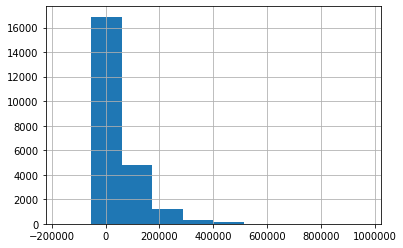

In [60]:
df[df['default']==0]['bill_amt1'].hist();